# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Howard Wang (b08902047@ntu.edu.tw)

If there are any questions, please contact mlta-2023-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [3]:
# Download dataset

!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files

!unzip real_or_drawing.zip

'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
UsageError: Line magic function `%unzip` not found.


In [ ]:
# ref:https://github.com/xiaoachen98/DALN
# 有附在zip內
# !git clone https://github.com/xiaoachen98/DALN.git

Cloning into 'DALN'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 36 (delta 9), reused 27 (delta 8), pack-reused 0
Unpacking objects: 100% (36/36), 142.89 KiB | 8.93 MiB/s, done.


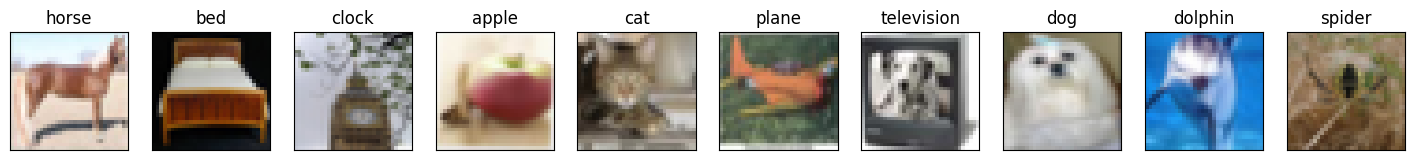

In [4]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

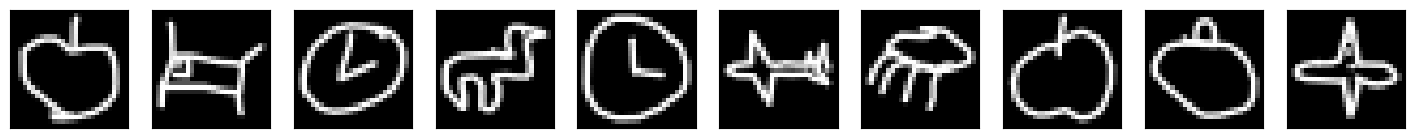

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

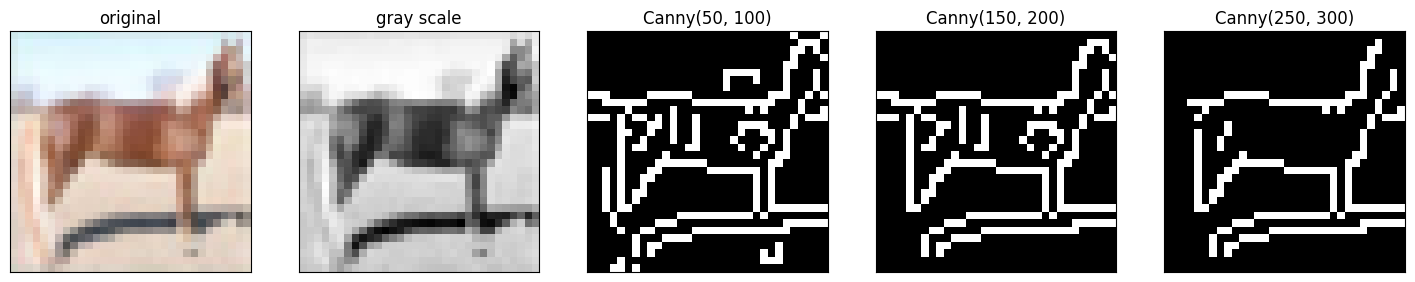

In [ ]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 

from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, track
import time


source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [7]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [40]:
from torchvision.models import resnet50

feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

d:\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
from DALN.nwd import NuclearWassersteinDiscrepancy
discrepancy = NuclearWassersteinDiscrepancy(label_predictor) # classifier is your own whole classification model
optimizer_dis = optim.Adam(discrepancy.parameters())

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [ ]:
def train_epoch(source_dataloader, target_dataloader, progress, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    batch_tqdm = progress.add_task(description=f"batch_progress", total=len(source_dataloader))

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        feature = feature_extractor(mixed_data)
        y_s = label_predictor(feature[:source_data.shape[0]])
        
        cls_loss = class_criterion(y_s, source_label)
        discrepancy_loss = -discrepancy(feature)
        transfer_loss = discrepancy_loss * lamb
        loss = cls_loss + transfer_loss

        running_F_loss+= loss.item()
        loss.backward()
        optimizer_dis.step()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_C.zero_grad()
        optimizer_F.zero_grad()
        optimizer_dis.zero_grad()
        

        total_hit += torch.sum(torch.argmax(y_s, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        progress.advance(batch_tqdm, advance=1)

    progress.remove_task(batch_tqdm)
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

num_epochs = 2000
# train 200 epochs

with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    epoch_tqdm = progress.add_task(description="epoch progress", total=num_epochs)
    for epoch in range(num_epochs):
        train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, progress, lamb=0.8)
            
        progress.advance(epoch_tqdm, advance=1)
        if epoch == 10:
          torch.save(feature_extractor.state_dict(), f'extractor_model_early.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_early.bin')
        elif epoch == 1000:
          torch.save(feature_extractor.state_dict(), f'extractor_model_mid.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_mid.bin')
          
        torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
        torch.save(label_predictor.state_dict(), f'predictor_model.bin')
        print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))



# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [17]:
result = []
label_predictor.eval()
feature_extractor.eval()
with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    test_tqdm = progress.add_task(description="inference progress", total=len(test_dataloader))
    for i, (test_data, _) in (enumerate(test_dataloader)):
        test_data = test_data.cuda()

        class_logits = label_predictor(feature_extractor(test_data))

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)
        progress.advance(test_tqdm)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

inference progress ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━  82% 0:00:10 0:00:44

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [79]:
# Hints:
# Set features_extractor to eval mode
# Load saved checkpoints
# Start evaluation and collect features and labels
feature_extractor.eval()
label_predictor.eval()
feature_extractor.load_state_dict(torch.load('extractor_model.bin'))
label_predictor.load_state_dict(torch.load('predictor_model.bin'))
result=[]
feature_list=[]

with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    
    test_tqdm = progress.add_task(description="inference progress", total=len(source_dataloader))

    for i, (source_data, source_label) in enumerate(source_dataloader):

        source_data = source_data.cuda()
        feature = feature_extractor(source_data)
        feature = feature.detach().cpu().numpy()
        feature_list.append(feature)    
        result.append(source_label)
        progress.advance(test_tqdm)
result = np.concatenate(result)
feature_list = np.concatenate(feature_list)

Output()

In [80]:
tot_idx = np.array([i for i in range(len(feature_list))])
select_idx = np.random.choice(tot_idx,size=5000,replace=False)
sne_feature = feature_list[select_idx]
sne_result = result[select_idx]


## Step2: Apply t-SNE and normalize

In [81]:
# process extracted features with t-SNE
X_tsne = manifold.TSNE(n_components=2, perplexity=30, init='random', random_state=5, verbose=1).fit_transform(sne_feature)

# Normalization the processed features 
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.576s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.581850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.384933
[t-SNE] KL divergence after 1000 iterations: 1.211203


## Step3: Visualization with matplotlib

C:\Users\OeO\AppData\Local\Temp\ipykernel_14424\3271525611.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', np.max(result) + 1)


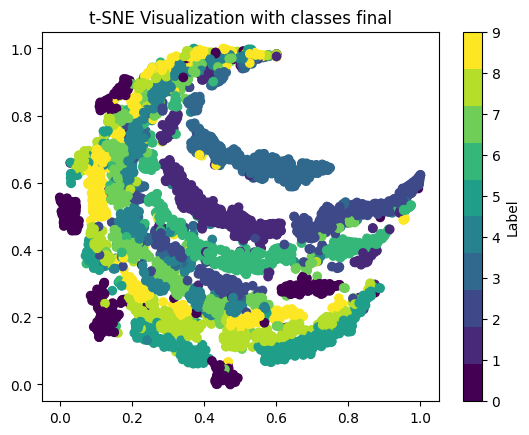

In [83]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)
embedded_data = X_norm
labels = result

colormap = plt.cm.get_cmap('viridis', np.max(result) + 1)

# Plot the t-SNE embeddings with different colors for different labels
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sne_result, cmap=colormap)

# Add colorbar and set labels
cbar = plt.colorbar()
cbar.set_ticks(np.arange(np.max(labels) + 1))
cbar.set_label('Label')

# Add title and show the plot
plt.title('t-SNE Visualization with classes final')
plt.show()


## Q2

In [101]:
feature_extractor.eval()
feature_extractor.load_state_dict(torch.load('extractor_model_early.bin'))
source_feature_list=[]
target_feature_list=[]

with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    
    test_tqdm = progress.add_task(description="inference progress", total=len(source_dataloader))

    for i, (source_data, source_label) in enumerate(source_dataloader):

        source_data = source_data.cuda()
        feature = feature_extractor(source_data)
        feature = feature.detach().cpu().numpy()
        source_feature_list.append(feature)    

    for i, (test_data, _) in (enumerate(test_dataloader)):
        
        test_data = test_data.cuda()
        feature = feature_extractor(test_data)
        feature = feature.detach().cpu().numpy()
        target_feature_list.append(feature)
        progress.advance(test_tqdm)

source_feature_list = np.concatenate(source_feature_list)
target_feature_list = np.concatenate(target_feature_list)

Output()

In [102]:
tot_idx = np.array([i for i in range(len(target_feature_list))])
select_idx = np.random.choice(tot_idx,size=5000,replace=False)
target_sne_feature = target_feature_list[select_idx]
source_sne_feature = source_feature_list
sne_feature = np.concatenate((source_sne_feature,target_sne_feature),axis=0)

In [103]:
# process extracted features with t-SNE
X_tsne = manifold.TSNE(n_components=2, perplexity=30, init='random', random_state=5, verbose=1).fit_transform(sne_feature)
# Normalization the processed features 
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 1.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.679064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.221123
[t-SNE] KL divergence after 1000 iterations: 1.879446


C:\Users\OeO\AppData\Local\Temp\ipykernel_14424\1162886459.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', np.max(labels) + 1)


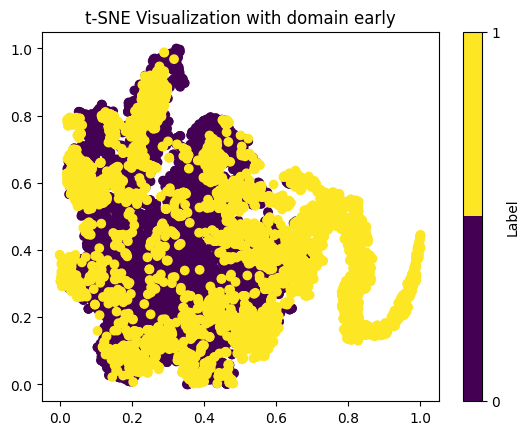

In [104]:
# Data Visualization

embedded_data = X_norm
labels = []

for i in range(10000):
    if i<5000:
        labels.append(0)
    else:
        labels.append(1)

colormap = plt.cm.get_cmap('viridis', np.max(labels) + 1)

# Plot the t-SNE embeddings with different colors for different labels
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=labels, cmap=colormap)

# Add colorbar and set labels
cbar = plt.colorbar()
cbar.set_ticks(np.arange(np.max(labels) + 1))
cbar.set_label('Label')

# Add title and show the plot
plt.title('t-SNE Visualization with domain early')
plt.show()

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08902047@ntu.edu.tw / mlta-2023-spring@googlegroups.com。

